# Portfolio Analysis of Communication services sector

### Stocks under observation:

    - Walt Disney Co. (NASDAQ: DIS)
    - Zoom Video Communications Inc (NASDAQ: ZM)
    - Netflix (NASDAQ:NFLX) 
    - Facebook (NASDAQ:FB)
    - Alphabet (NASDAQ:GOOGL)
    - Verizon (NYSE:VZ) 

In [34]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader import data as wb
import scipy.optimize as sco
import warnings

warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
np.random.seed(777)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Pulling stock data 

In [35]:
comms = ['DIS', 'ZM', 'NFLX', 'FB','GOOGL', 'VZ' ]
data = pd.DataFrame()
for i in range(len(comms)):
    
    df = wb.DataReader(comms[i], data_source='yahoo', start='2019-1-1', end = '2020-1-1')
    df['stock'] = comms[i]
    data = data.append(df[['Adj Close', 'stock']])

table = data.pivot(columns='stock')
# By specifying col[1] in below list comprehension
# You can select the stock names under multi-level column
table.columns = [col[1] for col in table.columns]
table.head()

,DIS,FB,GOOGL,NFLX,VZ,ZM
Date,,,,,,
2019-01-02,107.654343,135.679993,1054.680054,267.660004,52.626987,NaN
2019-01-03,105.046211,131.740005,1025.469971,271.200012,52.814873,NaN
2019-01-04,108.286606,137.949997,1078.069946,297.570007,52.946396,NaN
2019-01-07,109.225136,138.050003,1075.920044,315.339996,53.284599,NaN
2019-01-08,110.074753,142.529999,1085.369995,320.269989,54.844048,NaN


Text(0, 0.5, 'price in $')

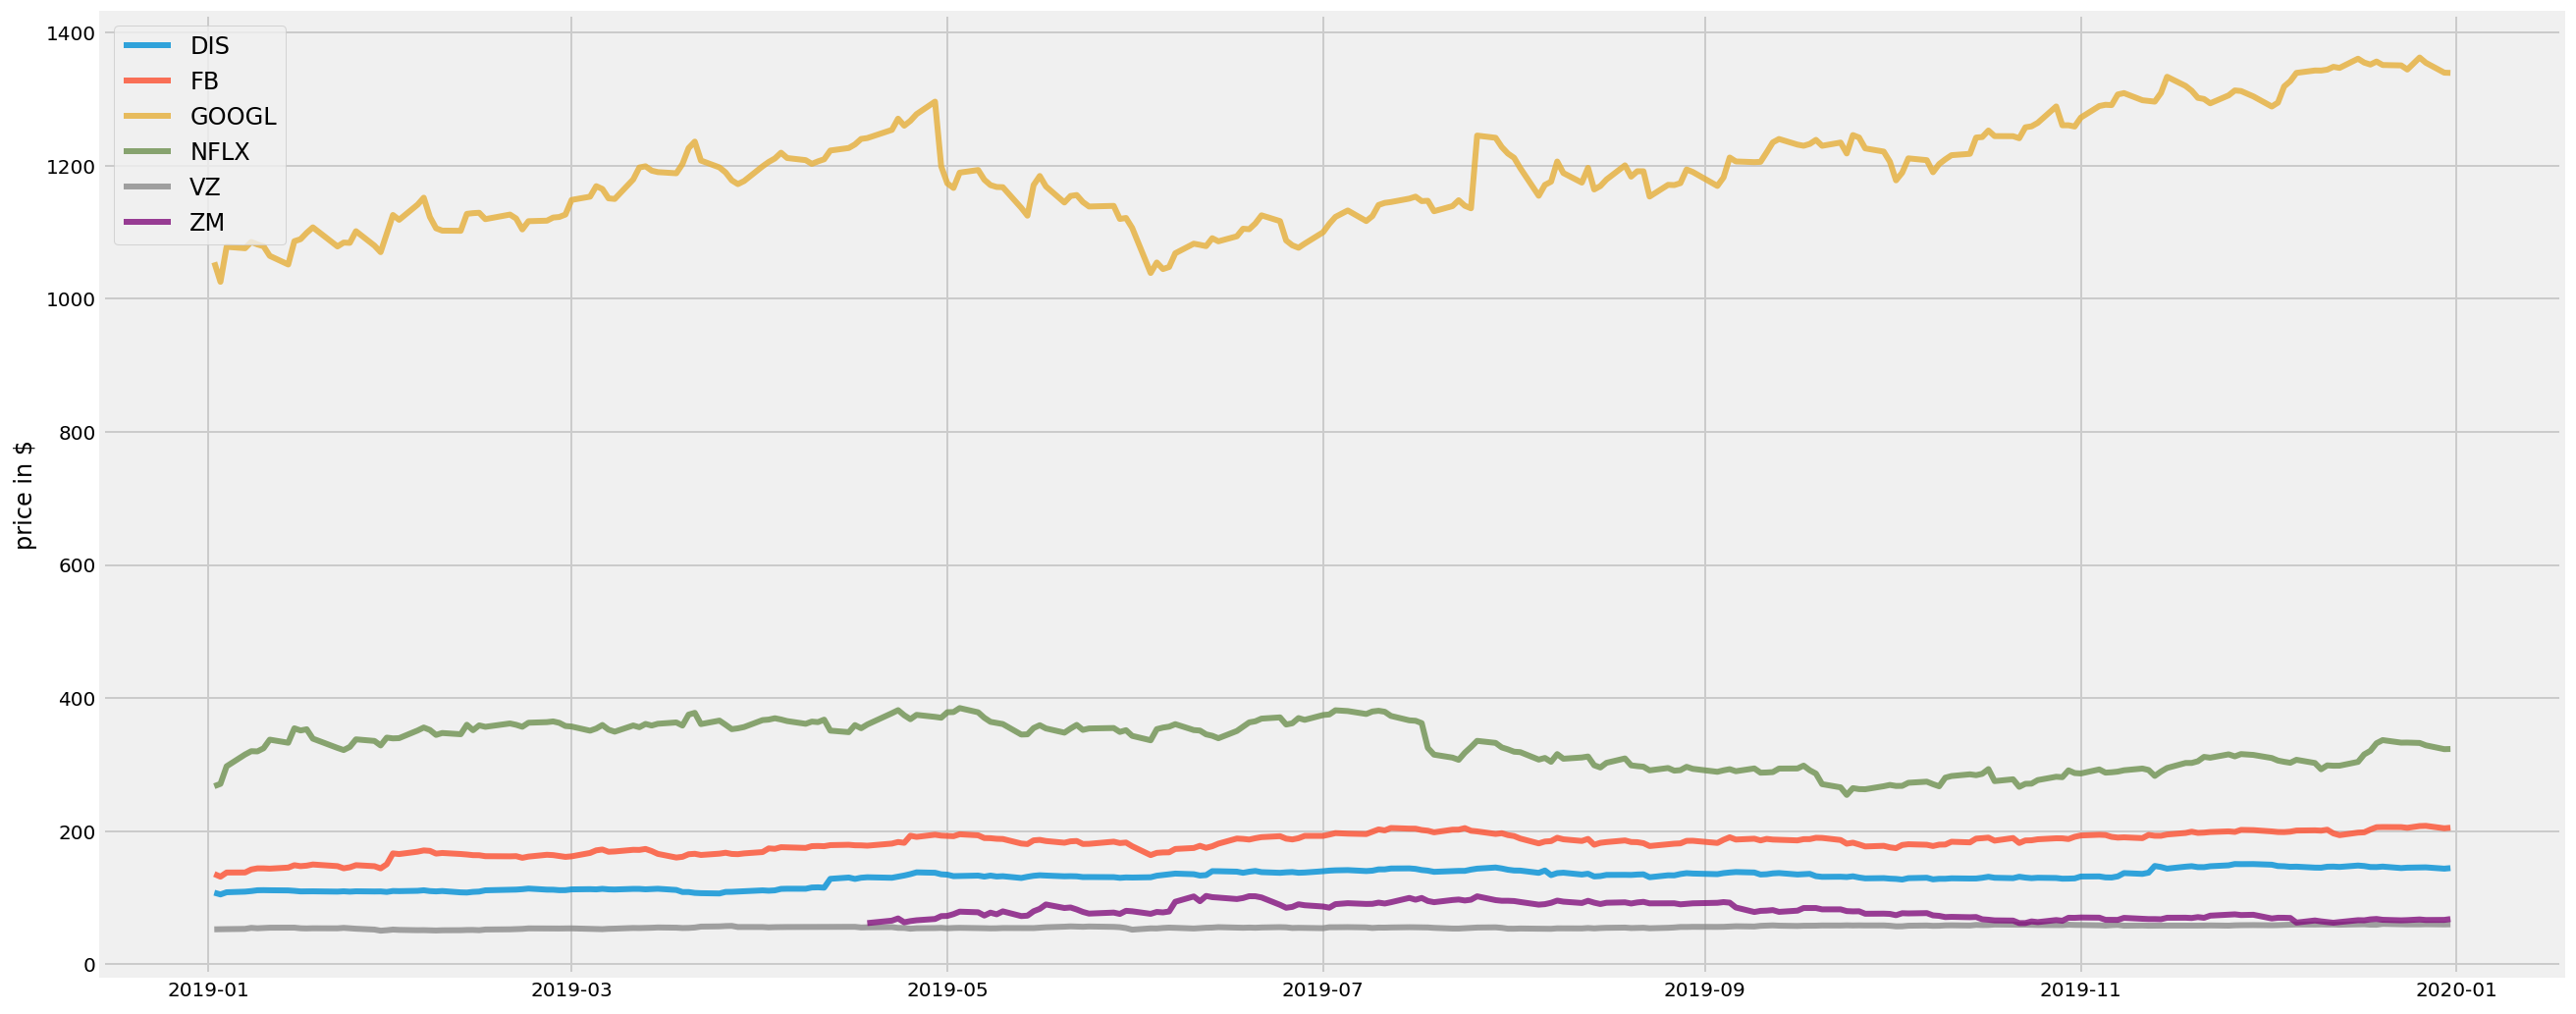

In [36]:
plt.figure(figsize=(20, 9))
for c in table.columns.values:
    plt.plot(table.index, table[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')

### Simple returns

Text(0, 0.5, 'daily returns')

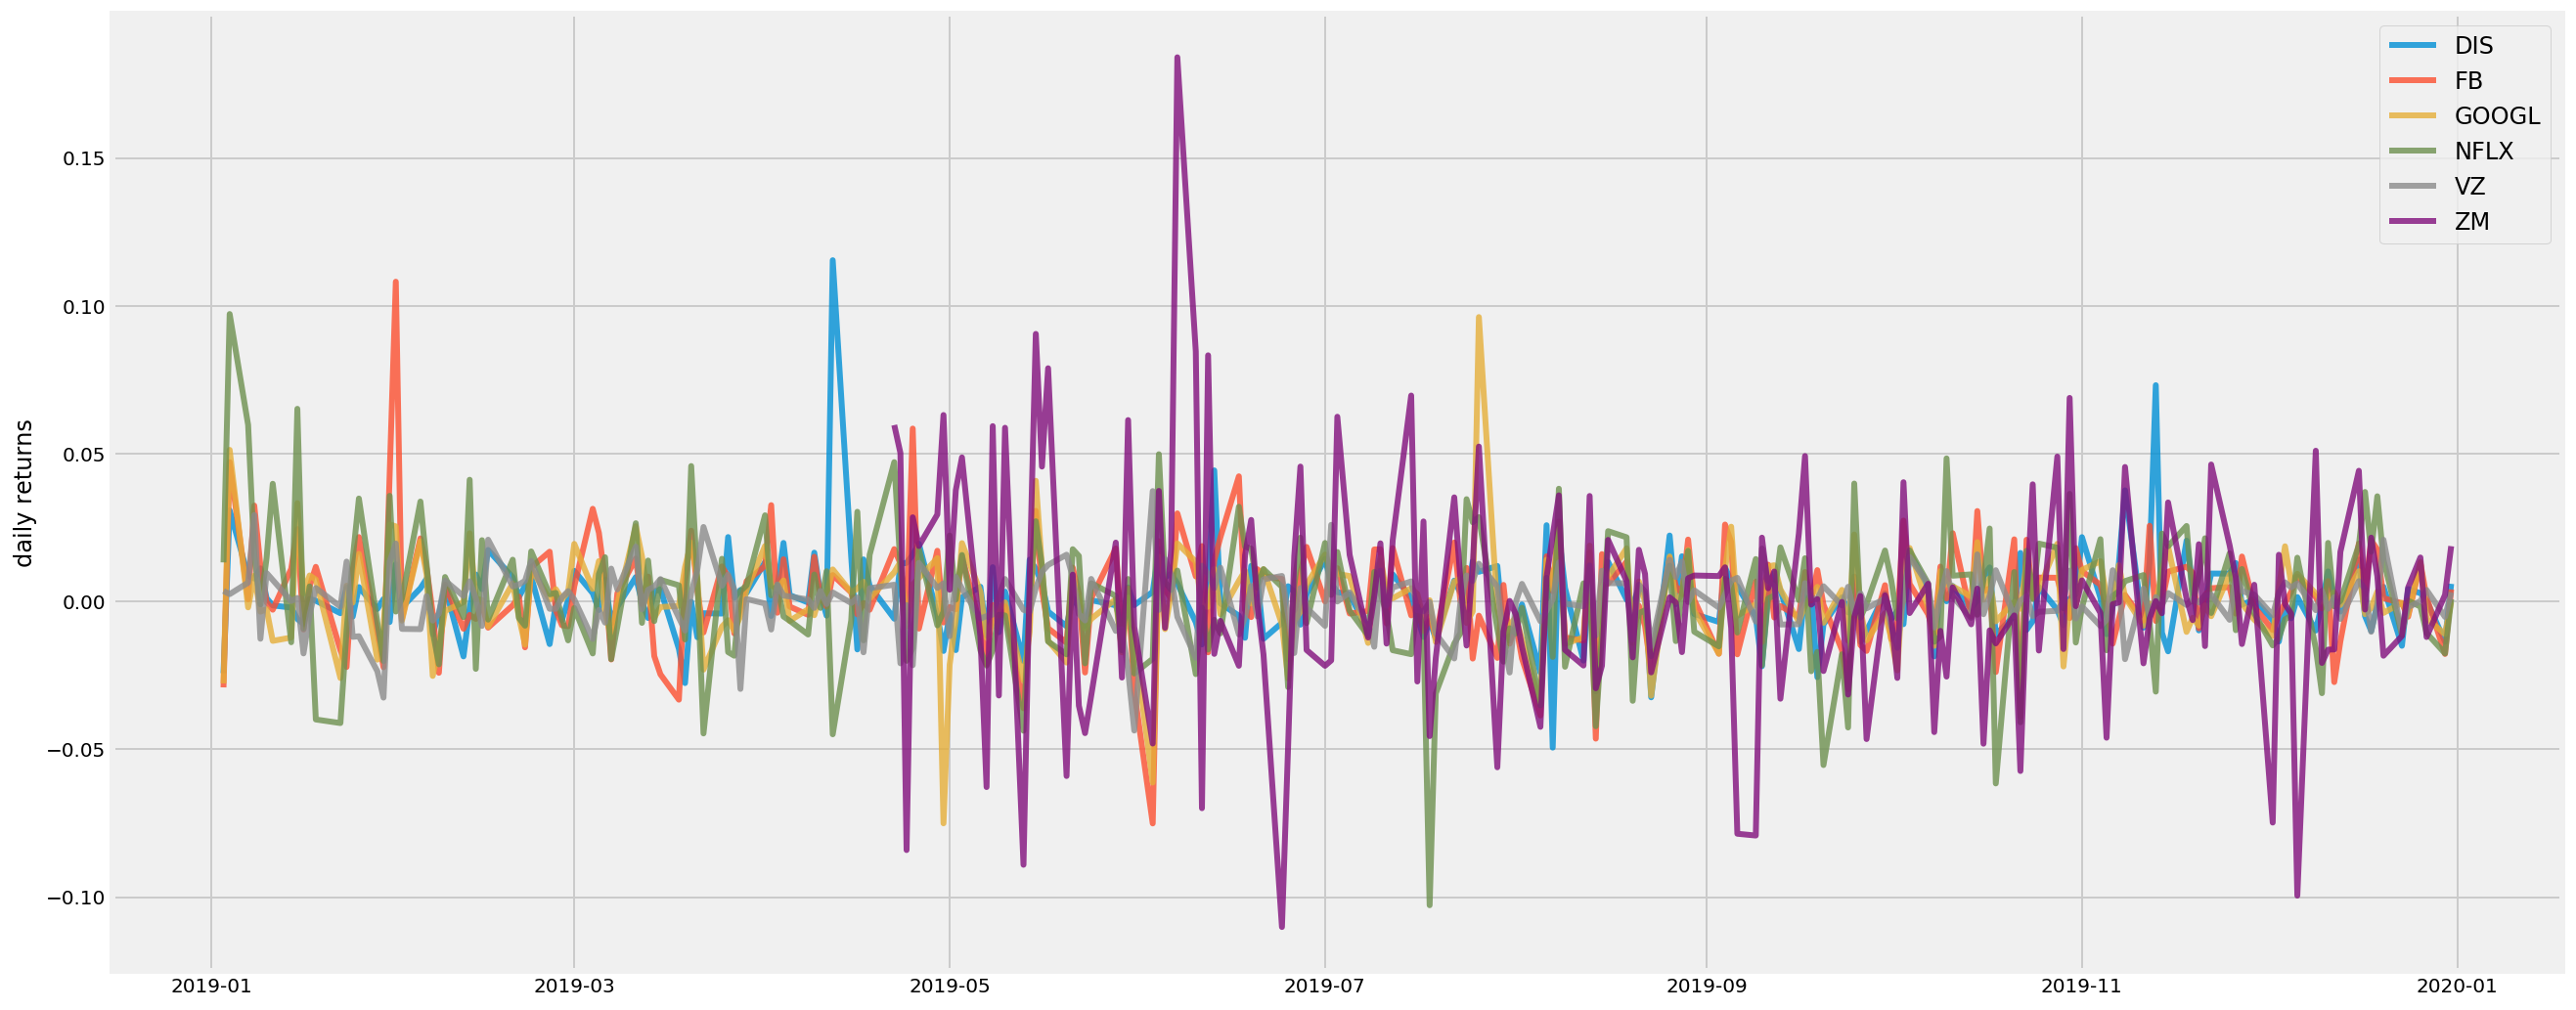

In [37]:
returns = table.pct_change()
plt.figure(figsize=(20, 9))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily returns')

### log returns

Text(0, 0.5, 'daily log returns')

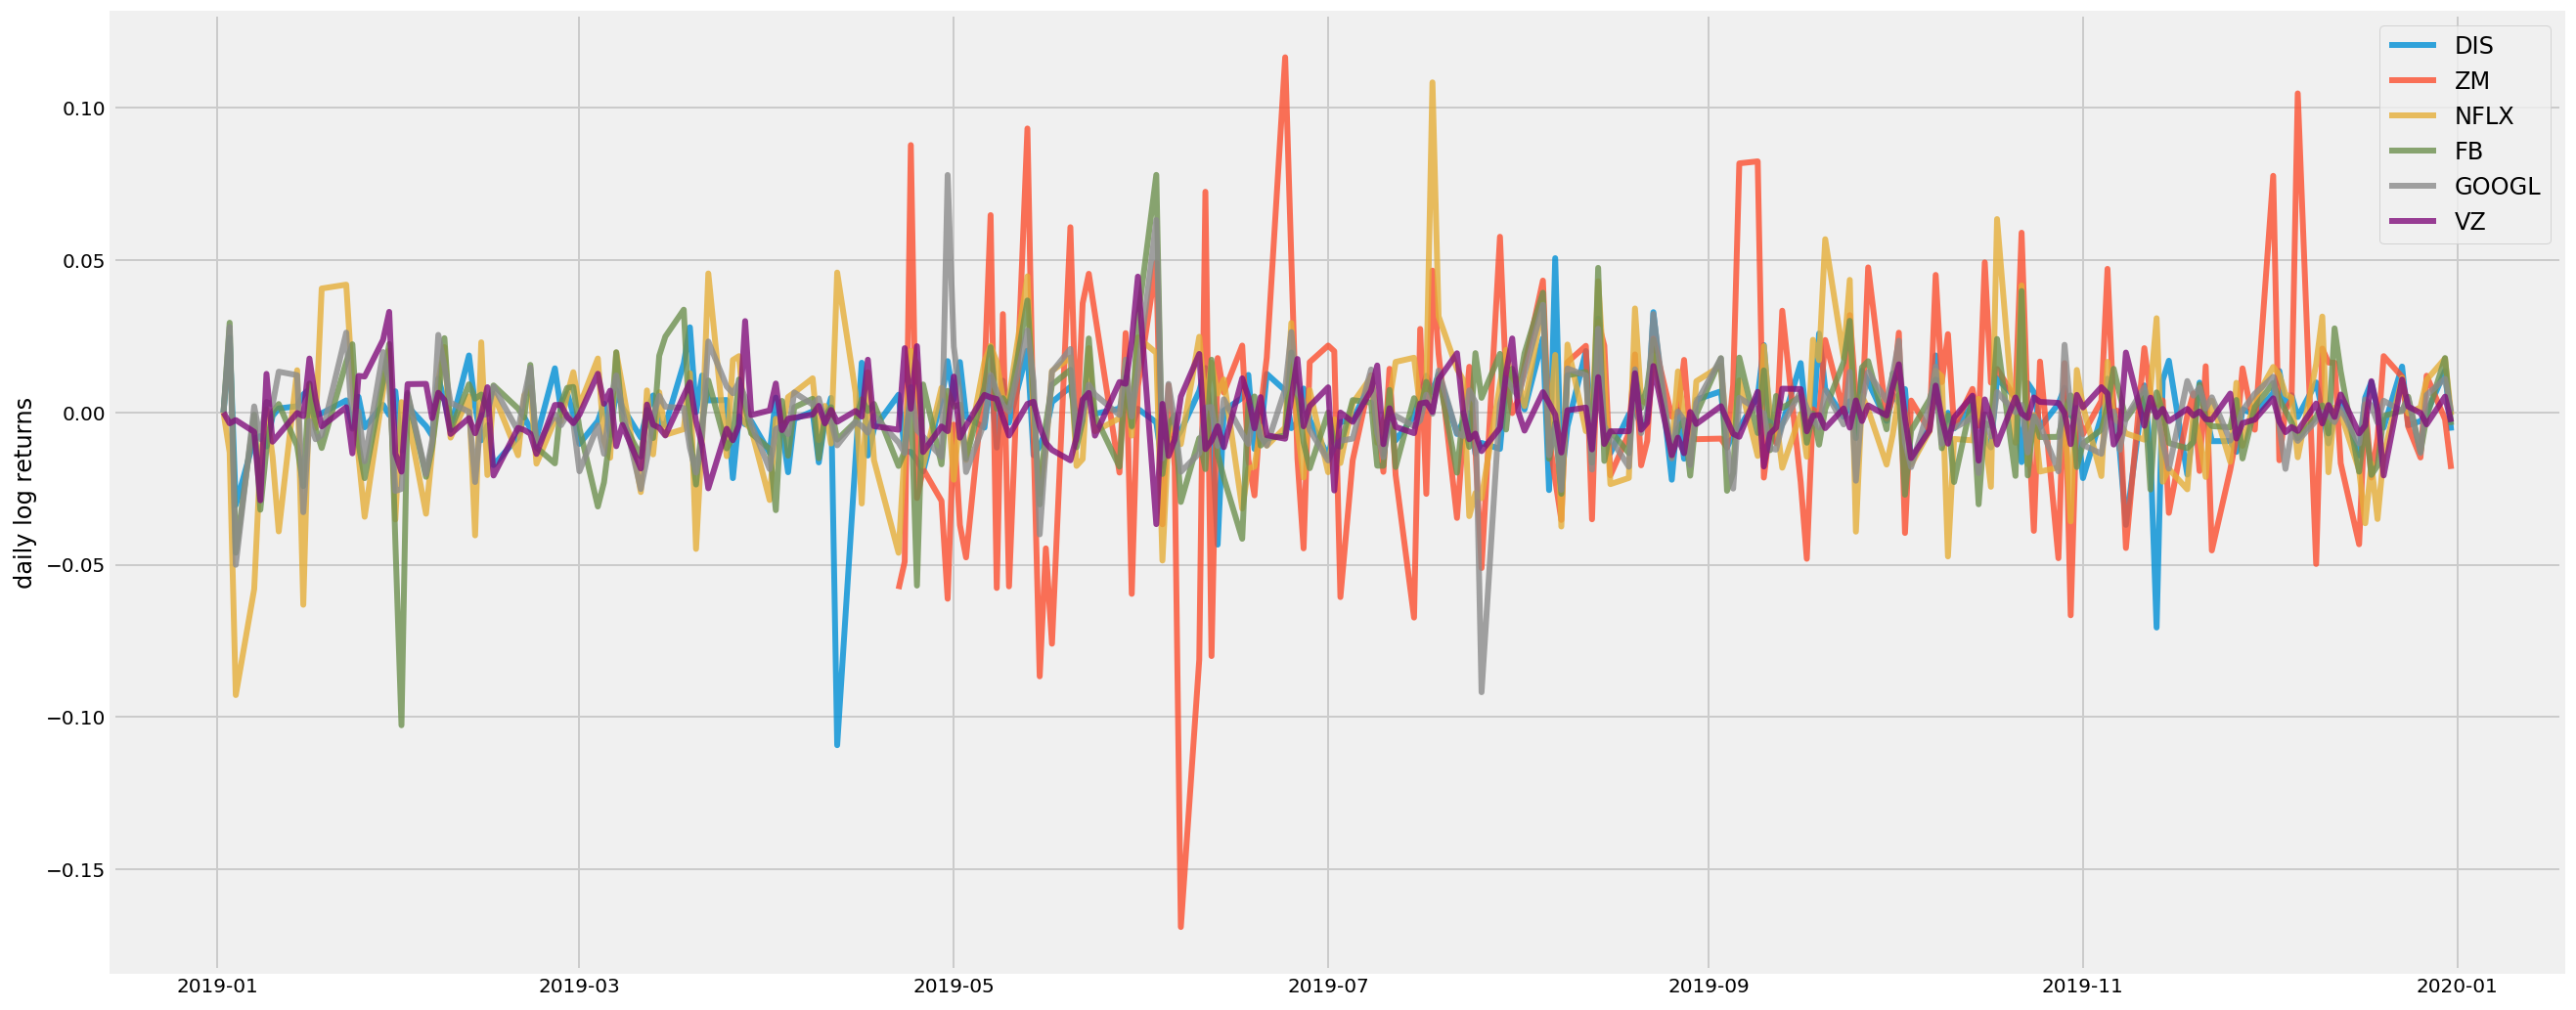

In [38]:
log = pd.DataFrame(columns = comms, index = table.index)

for i in range(len(comms)):
    log_list = []
    for j in range(len(table[comms[i]])):
        if(j+1<len(table[comms[i]])):
            log_returns =  np.log(table[comms[i]][j]) - np.log(table[comms[i]][j+1])
            log_list.append(log_returns)
            

        else:
            None
    log_list.insert(0, 0)   
    log[comms[i]] = log_list


plt.figure(figsize=(20, 9))
for c in log.columns.values:
     plt.plot(log.index, log[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily log returns')


### Normalization to 100

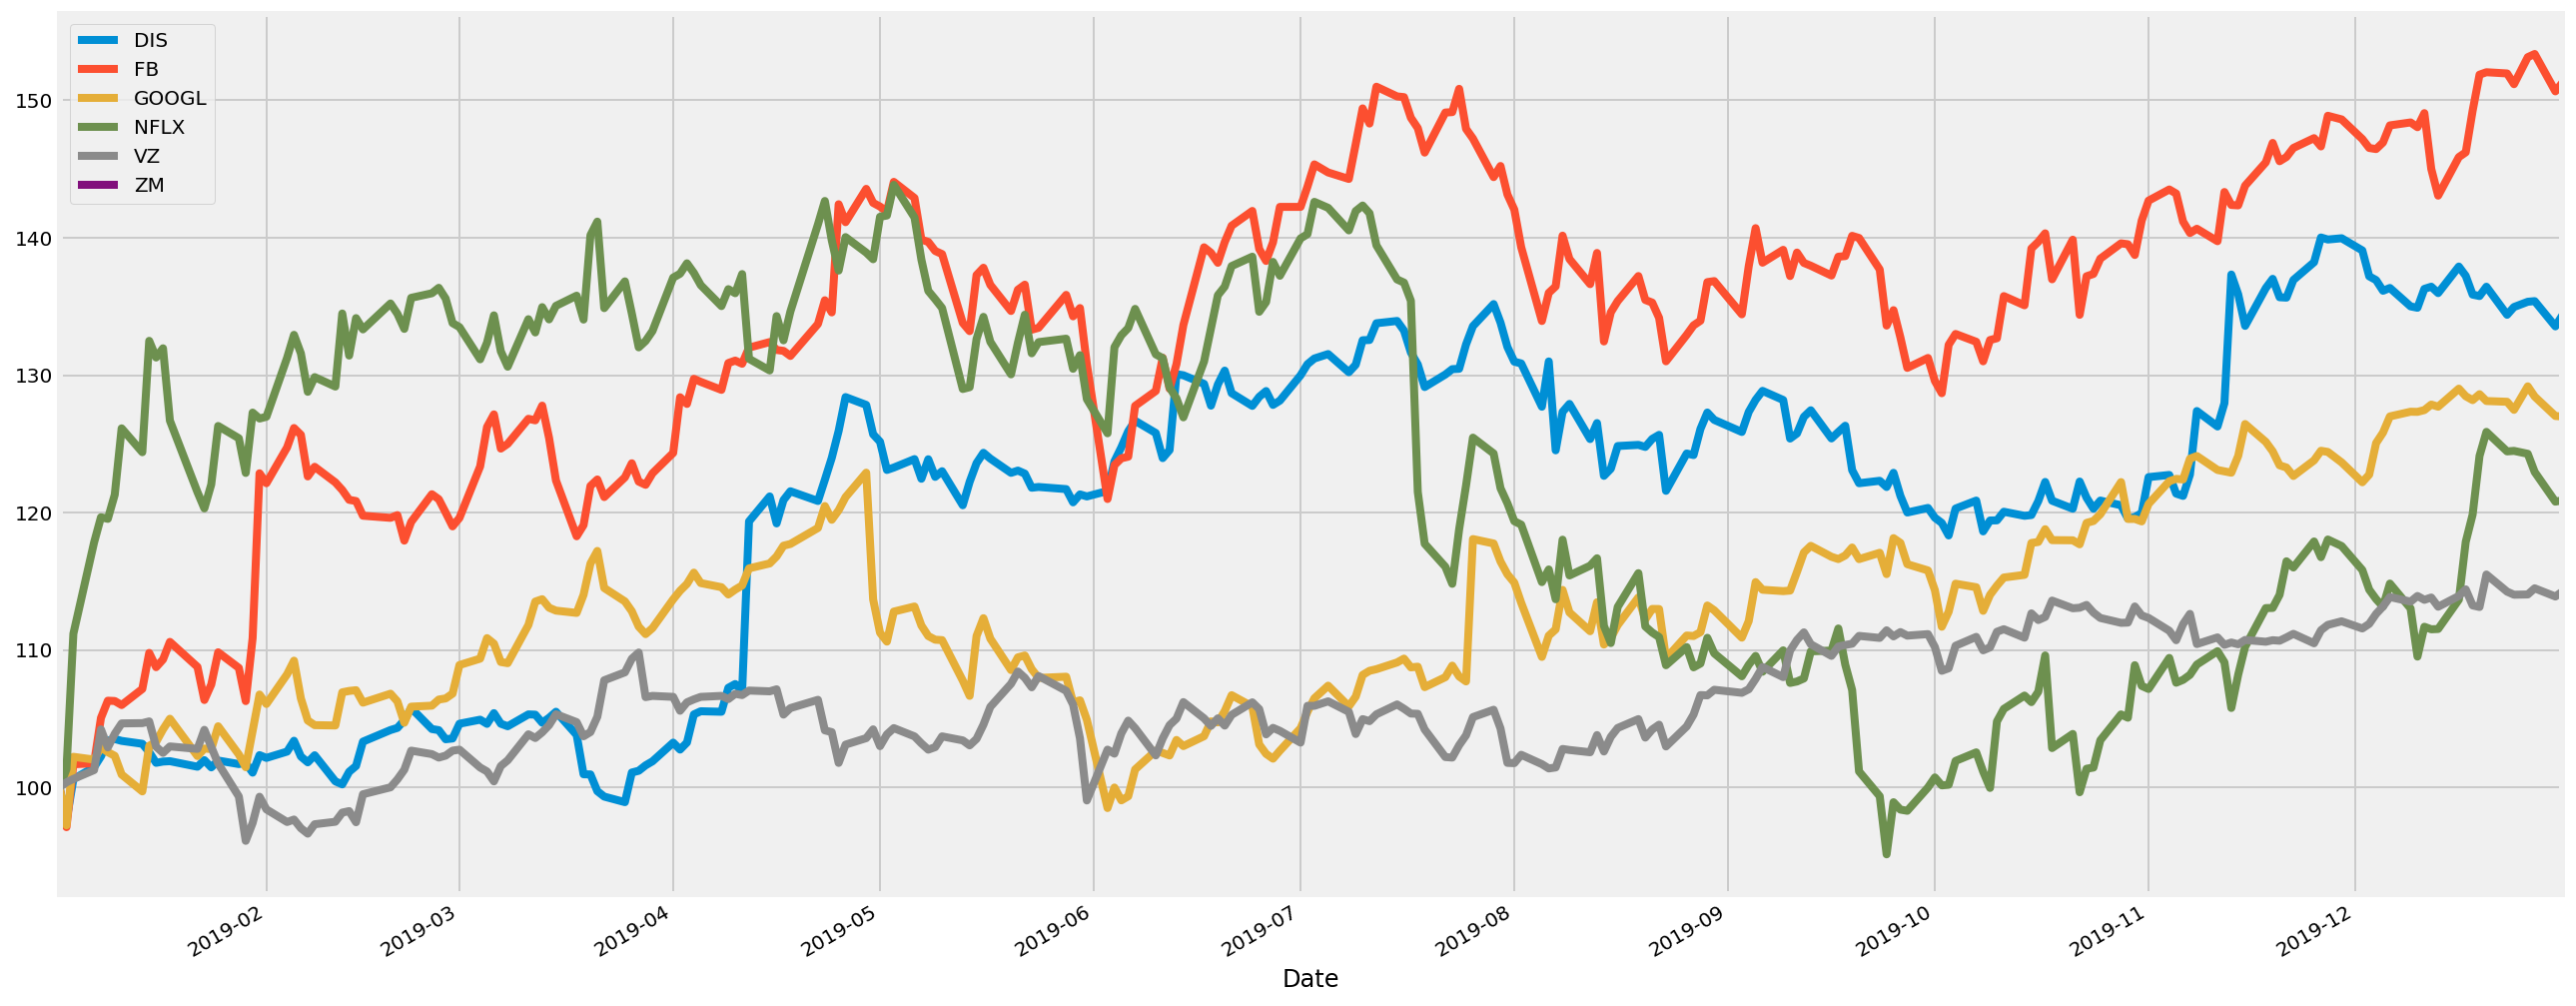

In [39]:
(table/table.iloc[0] * 100).plot(figsize = (20,9))
plt.show()

In [40]:
returns

,DIS,FB,GOOGL,NFLX,VZ,ZM
Date,,,,,,
2019-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-03,-0.024227,-0.029039,-0.027696,0.013226,0.003570,NaN
2019-01-04,0.030847,0.047138,0.051294,0.097234,0.002490,NaN
2019-01-07,0.008667,0.000725,-0.001994,0.059717,0.006388,NaN
2019-01-08,0.007779,0.032452,0.008783,0.015634,0.029266,NaN
...,...,...,...,...,...,...
2019-12-24,0.004216,-0.005141,-0.004590,0.000300,-0.001954,0.004686
2019-12-26,0.002822,0.013017,0.013418,-0.001711,0.000163,0.014896
2019-12-27,0.000343,0.001492,-0.005747,-0.010642,0.003916,-0.012009


In [41]:
log.mean()*252

DIS     -0.295253
ZM      -0.131608
NFLX    -0.189698
FB      -0.413930
GOOGL   -0.238977
VZ      -0.133130
dtype: float64

In [42]:
log.std()*252**0.5

DIS      0.221776
ZM       0.598247
NFLX     0.346405
FB       0.275150
GOOGL    0.236333
VZ       0.158644
dtype: float64

In [43]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns
  
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(6)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return(results, weights_record)

mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 50000
risk_free_rate = 0.02

def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print( "Maximum Sharpe Ratio Portfolio Allocation\n")
    print( "Annualised Return:", round(rp,2))
    print( "Annualised Volatility:", round(sdp,2))
    print( "\n")
    print( max_sharpe_allocation)
    print( "-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print( "Annualised Volatility:", round(sdp_min,2))
    print( "\n")
    print( min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.31
Annualised Volatility: 0.15


             DIS     FB  GOOGL  NFLX    VZ    ZM
allocation  30.3  32.67   4.98   0.1  31.3  0.66
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.24
Annualised Volatility: 0.13


              DIS     FB  GOOGL  NFLX     VZ   ZM
allocation  26.75  12.21   6.41  2.87  51.55  0.2


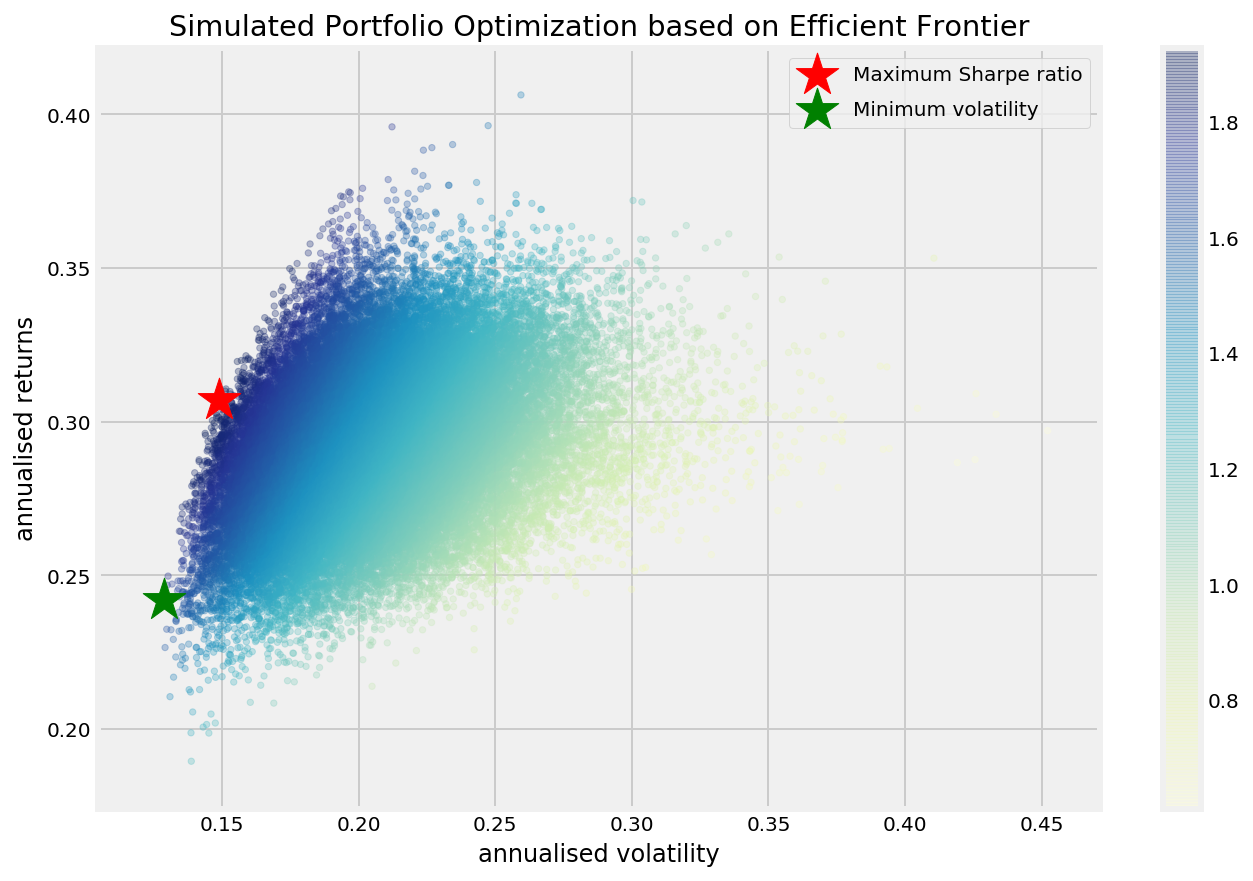

In [44]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)